# Experiments Using the Ruptures package

In this notebook we will experiment with several models from the [Ruptures](https://centre-borelli.github.io/ruptures-docs/) python package, which has several implemented methods for offline change point detection, wich can be used for Page Stream Segmentation. We will experiment with both the situation in which k is known, and the setting in which k is unknown. We will run experiments on the debug dataset, as well as on the D1 and D2 datasets. Because these methods are not trained, there is no real point in doing robustness experiments, but they will be evaluated on the other methods in the main results section of the paper.

## Index
- 1. [Loading in the data](#dataloading)
- 2. [Implementing the methods](#methods)
- 3. [Using Different vectors Types](#different_vector_types)

## Different models in the Ruptures package

There are various algorithms implemented in the Ruptures package, with some distinctions between the different models. If we are dealing with a setting where we know the number of change-points, then we can use a method such as Dynamic Progrom to do the detection. However, if we have a situation where we do not know the number of changepoints in advance, we rely on different methods such as Pelt with a known cost function (see next paragraph). There are also various methods that can handle both situations such as Binary Segmentation and Bottom Up Segmentation.

Apart from the  different options depending on the availability of K, the cost function is also an important choice in the Ruptures package. Following the examples for text segmentation from the Ruptures, package, we implement the Cosine Similarity as the similarity measure between different points / pages in our signal. This similarity can then be used as a cost for finding the optimal segmentation.

<a id="dataloading">

## Loading in the data

In [1]:
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np

import ruptures
from ruptures.base import BaseCost
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%run metricutils.py

In [4]:
# We first experiment with the debug dataset, as it is much smaller than the other two datasets.
# We will load in the data of the other datasets as well.
D1_train = pd.read_csv('../resources/datasets/LONG/dataframes/train.csv')
D1_test = pd.read_csv('../resources/datasets/LONG/dataframes/test.csv')

D2_train = pd.read_csv('../resources/datasets/SHORT/dataframes/train.csv')
D2_test = pd.read_csv('../resources/datasets/SHORT/dataframes/test.csv')

### Known-K segmentation

In the case that the number of changepoints is known, we can make use of Dynamic Programming to get the optimal segmentation. In our case we are using cosine similarity, so we want to find the segmentation that minimizes the sum of segment costs. Because we use sparse vectors and the standard CosineCost in ruptures does not exploit this (slowing down the process quite a bit), we reimplement the cost function to make it more suited for our specific example.

### Unknown Segmentation

In the case where we do not know the number of segments in advance, we will have to use different methods, such as the Pelt Segmentation algorithm, or different methods such as Binary Segmentation or Bottom Up segmentation.

<a id="methods">

## Implementing the Prediction Pipeline

### Creating the Cosine Similarity Function

In [5]:
# Define the custom cosine loss
class CosineCost(BaseCost):
    model = "CustomCosine"
    min_size = 1
    
    def fit(self, signal) -> None:
        self.signal = signal
        self.gram = cosine_similarity(signal, dense_output=False)
        return self
    
    def error(self, start, end) -> float:
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub_gram = self.gram[start:end, start:end]
        val = sub_gram.diagonal().sum()
        val -= sub_gram.sum() / (end - start)
        return val
        

### TF-IDF experiments

We will experiment with the usage of TF-IDF vectors first, both on the debug dataset and the other datasets, and also run the robustness experiments.

In [6]:
def create_tfidf_vectors(train_dataframe, test_dataframe, nan_fill: str = "NONE"):
    
    vector_dict = {}
    # Train on the train dataframe, and use this to predict on the
    # test dataframe.
    vectorizer = TfidfVectorizer(ngram_range=(3, 3), analyzer='char')
    train_text = train_dataframe.text.fillna(nan_fill).tolist()
    vectorizer.fit(train_text)
    
    # Loop over all streams and get the tf idf vectors for them
    for stream_id, stream_dataframe in tqdm(test_dataframe.groupby('name')):
        stream_vectors = vectorizer.transform(stream_dataframe.text.fillna('NONE'))
        vector_dict[stream_id] = stream_vectors

    return vector_dict

Because there is no clear 'training' in this approach, we will just run our model in the test set directly, and report the scores. Beware, this package puts the changepoint index as the end of a sequence! This means that we have to translate this to our approach by shiften the prediction up 1 for each index. However, because I think they also let the index start at 1 instead of 0, we should be ok with the setting we have now.

In [7]:
def extract_changepoints(list_of_changepoints: list) -> np.ndarray:
    # Last changepoint is just the index of the signal
    output_signal = np.zeros(shape=(list_of_changepoints[-1]))
    output_signal[[item for item in list_of_changepoints[:-1]]] = 1
    return output_signal
    

To make the models and methods easier to work with and more modular, we will assume the input to the predict function to already be a dictionary with a matrix of page vectors for each stream.

In [8]:

#algo_c = rpt.KernelCPD(kernel="linear", min_size=2).fit(signal)  # written in C

# Karakter n grammen werken hier het best.
def predict(dataframe, stream_dict, known_k: bool = True, method="dynamic",
           penalty: float = None) -> dict:
    
    assert method in ["dynamic", "pelt", "binary", "windowed", "bottomup"]
    if (known_k and method == "pelt") or (not known_k and method == "dynamic"):
        raise ValueError
    
    predictions = {}
    # Number of change points is simply the number of documents minus 1
    changepoint_lookup = dataframe.groupby('name')['label'].sum()-1
    
    algorithms = {'dynamic': ruptures.KernelCPD,
                 'pelt': ruptures.KernelCPD,
                 'binary': ruptures.Binseg,
                 'bottomup': ruptures.BottomUp,
                 'windowed': ruptures.Window}
    
    # Implement the main prediction loop
    for stream_id, vectors in tqdm(stream_dict.items()):
        if method in ['pelt', 'dynamic']:
            split_algo = algorithms[method](kernel='cosine', min_size=1, jump=1).fit(vectors)
        else:
            split_algo = algorithms[method](custom_cost=CosineCost, min_size=1, jump=1).fit(vectors)
        num_changepoints = changepoint_lookup[stream_id]
        if known_k:
            if not num_changepoints:
                predicted_breaks = np.zeros(shape=(vectors.shape[0], 1))
                predicted_breaks[0] = 1
                predictions[stream_id] = dataframe[dataframe.name == stream_id].label.tolist()
                continue
                
            if method in ['binary', 'bottomup', 'windowed'] and penalty:
                predicted_breaks = split_algo.predict(n_bkps=num_changepoints, pen=penalty)   
            else:
                predicted_breaks = split_algo.predict(n_bkps=num_changepoints)
        else:
            predicted_breaks = split_algo.predict(pen=penalty)

        prediction_array = extract_changepoints(predicted_breaks)
        predictions[stream_id] = prediction_array
        
    return predictions
        
        

To facilitate the ease of experimenting, we will create a small function that, given whether k is known or not, runs all the algorithms in the ruptures package.

In [9]:
def experiment(test_dataframe, test_vectors, known_k: bool, penalty: float=None,
              average_results: bool = True):
    
    method_results = {}
    
    if known_k:
        methods = ['dynamic', 'bottomup', 'binary', 'windowed']
        #methods = ['bottomup']
    else:
        methods = ['pelt', 'bottomup', 'binary', 'windowed']
        # methods = ['bottomup']
    
    ground_truth = get_ground_truth_from_dataframe(test_dataframe, col='label')
    
    for method in methods:
        print(method)
        predictions = predict(test_dataframe, test_vectors, known_k=known_k,
                              method=method, penalty=penalty)
        if average_results:
            method_scores = evaluation_report(ground_truth, predictions)
        else:
            method_scores = calculate_scores_df(ground_truth, predictions)
            
        method_results[method] = method_scores
    combined_dataframe = pd.concat([method_results[item] for item in method_results.keys()], keys=method_results.keys(),
              axis=1, names=["model", "metric"])
    return combined_dataframe
        
    
    

It is interesting to see that for the binary approach, there is barely a difference between whether we do or do not know k, and in the case were we do not know k it is even a bit better.

Now we run the experiment for the other two datasets, and collect the results. Because of the very long runtime, and the limited performance, we exlucde the PELT and Dynp methods from these evaluation, as they have shown not to obtain superior performance.

#### D1 dataset

In [11]:
D1_tfidf_vectors = create_tfidf_vectors(D1_train, D1_test)
D1_experiment_results_k = experiment(D1_test, D1_tfidf_vectors, known_k=True)
D1_experiment_results_k[:].loc['Boundary', :].unstack()

KeyboardInterrupt: 

In [54]:
D1_experiment_results_no_k = experiment(D1_test, D1_tfidf_vectors, known_k=False, penalty=0.5)
D1_experiment_results_no_k[:].loc['Boundary', :].unstack()

bottomup


100%|██████████| 34/34 [00:42<00:00,  1.24s/it]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
bottomup,0.38,0.88,0.49,6347,0.37-0.39,0.88-0.88,0.48-0.5


#### D2 dataset

In [55]:
D2_tfidf_vectors = create_tfidf_vectors(D2_train, D2_test)
D2_experiment_results_k = experiment(D2_test, D2_tfidf_vectors, known_k=True)
D2_experiment_results_k[:].loc['Boundary', :].unstack()

100%|██████████| 108/108 [00:10<00:00, 10.21it/s]


bottomup


100%|██████████| 108/108 [00:10<00:00, 10.57it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
bottomup,0.61,0.61,0.61,1404,0.58-0.64,0.58-0.64,0.58-0.64


In [56]:
D2_experiment_results_no_k = experiment(D2_test, D2_tfidf_vectors, known_k=False, penalty=0.5)
D2_experiment_results_no_k[:].loc['Boundary', :].unstack()

bottomup


100%|██████████| 108/108 [00:06<00:00, 15.63it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
bottomup,0.37,0.95,0.48,1404,0.36-0.38,0.95-0.95,0.47-0.49


The results here are quite interesting, as it seems that not knowing k actually makes the model improves in recall. This means that, although we place the correct number of boundaries if we know k, we often place them wrong. If we don't know k, our precision drops as we put in too many boundaries, but our recall increased, as we are getting more boundaries.

<a id="different_vector_types">

## Different Vector Types

In the above experiments we have worked with TFIDF vectors, in this part of the notebook we will work with the pretrained text and image vectors instead, to see if we can improve the performance of the models using the more refined vectors. We will use pretrained embeddings from BERT for text, and pretrained embeddings from VGG16 from images. Because we are using methods that cannot really be trained, the robustness experiment is not applicable here. One could argue that we could use pretrained vectors here, which is something that could be done in future work.

In [8]:
# Load the standard and robust image vectors
D1_standard_image_vectors = np.load('../vector_data/image_vectors/D1/test_vectors.npy', allow_pickle=True)[()]
D2_standard_image_vectors = np.load('../vector_data/image_vectors/D2/test_vectors.npy', allow_pickle=True)[()]

# Load the standard and robust text vectors
D1_standard_text_vectors = np.load('../vector_data/bert_vectors/D1/test_vectors.npy', allow_pickle=True)[()]
D2_standard_text_vectors = np.load('../vector_data/bert_vectors/D2/test_vectors.npy', allow_pickle=True)[()]

### Image Vectors

In [34]:
D1_image_standard_results_k = experiment(D1_test, D1_standard_image_vectors, known_k=True)
D1_image_standard_results_k[:].loc['Boundary', :].unstack()

D1_image_standard_results_no_k = experiment(D1_test, D1_standard_image_vectors, known_k=False, penalty=0.5)
D1_image_standard_results_no_k[:].loc['Boundary', :].unstack()

dynamic


100%|██████████| 34/34 [03:04<00:00,  5.42s/it]


bottomup


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


binary


100%|██████████| 34/34 [23:26<00:00, 41.36s/it] 


windowed


100%|██████████| 34/34 [00:22<00:00,  1.54it/s]


pelt


100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


bottomup


100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


binary


100%|██████████| 34/34 [24:12<00:00, 42.73s/it] 


windowed


100%|██████████| 34/34 [00:24<00:00,  1.37it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
pelt,0.58,0.19,0.21,6347,0.56-0.6,0.17-0.21,0.19-0.23
bottomup,0.33,1.0,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
binary,0.33,1.0,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
windowed,0.76,0.09,0.12,6347,0.7-0.82,0.05-0.13,0.07-0.17


In [39]:
D1_image_standard_results_k[:].loc['Boundary', :].unstack()

metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
dynamic,0.48,0.48,0.48,6347,0.47-0.49,0.47-0.49,0.47-0.49
bottomup,0.48,0.48,0.48,6347,0.47-0.49,0.47-0.49,0.47-0.49
binary,0.49,0.49,0.49,6347,0.48-0.5,0.48-0.5,0.48-0.5
windowed,0.76,0.09,0.12,6347,0.7-0.82,0.05-0.13,0.07-0.17


In [37]:
D2_image_standard_results_k = experiment(D2_test, D2_standard_image_vectors, known_k=True)
D2_image_standard_results_k[:].loc['Boundary', :].unstack()

D2_image_standard_results_no_k = experiment(D2_test, D2_standard_image_vectors, known_k=False, penalty=0.5)
D2_image_standard_results_no_k[:].loc['Boundary', :].unstack()

dynamic


100%|██████████| 108/108 [00:12<00:00,  8.64it/s]


bottomup


100%|██████████| 108/108 [00:03<00:00, 33.68it/s]


binary


100%|██████████| 108/108 [01:07<00:00,  1.61it/s]


windowed


100%|██████████| 108/108 [00:05<00:00, 19.37it/s]


pelt


100%|██████████| 108/108 [00:01<00:00, 70.02it/s] 


bottomup


100%|██████████| 108/108 [00:01<00:00, 94.11it/s]


binary


100%|██████████| 108/108 [01:17<00:00,  1.39it/s]


windowed


100%|██████████| 108/108 [00:05<00:00, 19.02it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
pelt,0.57,0.5,0.46,1404,0.55-0.59,0.48-0.52,0.44-0.48
bottomup,0.26,1.0,0.39,1404,0.25-0.27,1.0-1.0,0.38-0.4
binary,0.26,1.0,0.39,1404,0.25-0.27,1.0-1.0,0.38-0.4
windowed,0.89,0.31,0.41,1404,0.8-0.98,0.18-0.44,0.28-0.54


In [38]:
D2_image_standard_results_k[:].loc['Boundary', :].unstack()

metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
dynamic,0.53,0.53,0.53,1404,0.5-0.56,0.5-0.56,0.5-0.56
bottomup,0.52,0.52,0.52,1404,0.49-0.55,0.49-0.55,0.49-0.55
binary,0.51,0.51,0.51,1404,0.48-0.54,0.48-0.54,0.48-0.54
windowed,0.89,0.31,0.41,1404,0.81-0.97,0.19-0.43,0.29-0.53


### Text Vectors

In [40]:
D1_text_standard_results_k = experiment(D1_test, D1_standard_text_vectors, known_k=True)
D1_text_standard_results_k[:].loc['Boundary', :].unstack()

D1_text_standard_results_no_k = experiment(D1_test, D1_standard_text_vectors, known_k=False, penalty=0.5)
D1_text_standard_results_no_k[:].loc['Boundary', :].unstack()

dynamic


100%|██████████| 34/34 [00:56<00:00,  1.67s/it]


bottomup


100%|██████████| 34/34 [00:07<00:00,  4.65it/s]


binary


100%|██████████| 34/34 [03:02<00:00,  5.38s/it]


windowed


100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


pelt


100%|██████████| 34/34 [00:02<00:00, 13.43it/s]


bottomup


100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


binary


100%|██████████| 34/34 [04:04<00:00,  7.18s/it]


windowed


100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
pelt,0.65,0.12,0.14,6347,0.62-0.68,0.1-0.14,0.12-0.16
bottomup,0.33,1.0,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
binary,0.33,1.0,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
windowed,0.82,0.09,0.12,6347,0.76-0.88,0.05-0.13,0.07-0.17


In [41]:
D1_text_standard_results_k[:].loc['Boundary', :].unstack()

metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
dynamic,0.48,0.48,0.48,6347,0.47-0.49,0.47-0.49,0.47-0.49
bottomup,0.47,0.47,0.47,6347,0.46-0.48,0.46-0.48,0.46-0.48
binary,0.47,0.47,0.47,6347,0.46-0.48,0.46-0.48,0.46-0.48
windowed,0.82,0.09,0.12,6347,0.76-0.88,0.05-0.13,0.07-0.17


In [42]:
D2_text_standard_results_k = experiment(D2_test, D2_standard_text_vectors, known_k=True)
D2_text_standard_results_k[:].loc['Boundary', :].unstack()

D2_text_standard_results_no_k = experiment(D2_test, D2_standard_text_vectors, known_k=False, penalty=0.5)
D2_text_standard_results_no_k[:].loc['Boundary', :].unstack()

dynamic


100%|██████████| 108/108 [00:02<00:00, 43.49it/s]


bottomup


100%|██████████| 108/108 [00:02<00:00, 49.55it/s]


binary


100%|██████████| 108/108 [00:11<00:00,  9.69it/s]


windowed


100%|██████████| 108/108 [00:01<00:00, 69.98it/s]


pelt


100%|██████████| 108/108 [00:00<00:00, 135.09it/s]


bottomup


100%|██████████| 108/108 [00:01<00:00, 95.63it/s]


binary


100%|██████████| 108/108 [00:16<00:00,  6.54it/s]


windowed


100%|██████████| 108/108 [00:01<00:00, 73.78it/s]


metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
pelt,0.73,0.35,0.42,1404,0.69-0.77,0.3-0.4,0.37-0.47
bottomup,0.26,1.0,0.39,1404,0.25-0.27,1.0-1.0,0.38-0.4
binary,0.26,1.0,0.39,1404,0.25-0.27,1.0-1.0,0.38-0.4
windowed,0.89,0.31,0.4,1404,0.8-0.98,0.18-0.44,0.26-0.54


In [43]:
D2_text_standard_results_k[:].loc['Boundary', :].unstack()

metric,precision,recall,F1,support,CI Precision,CI Recall,CI F1
model,,,,,,,
dynamic,0.54,0.54,0.54,1404,0.51-0.57,0.51-0.57,0.51-0.57
bottomup,0.55,0.55,0.55,1404,0.52-0.58,0.52-0.58,0.52-0.58
binary,0.55,0.55,0.55,1404,0.52-0.58,0.52-0.58,0.52-0.58
windowed,0.89,0.31,0.41,1404,0.81-0.97,0.19-0.43,0.28-0.54


In [57]:
def save_json(filename, json_dict):
    with open(filename, 'w') as file:
        
        json.dump({key:list(value) for key, value in json_dict.items()}, file)
    return None

## Beste modellen voor elke setting, opslaan van resultaten

### Image modellen

In [50]:
D1_image_k = predict(D1_test, D1_standard_image_vectors, known_k=True, method="binary")
D1_image_no_k = predict(D1_test, D1_standard_image_vectors, known_k=False, method="bottomup", penalty=0.5)

100%|██████████| 34/34 [00:04<00:00,  6.90it/s]


In [58]:
save_json('../experiment_notebooks/experiment_results/RUPTURE-K-IMAGE/D1/predictions.json', D1_image_k)
save_json('../experiment_notebooks/experiment_results/RUPTURE-NO-K-IMAGE/D1/predictions.json', D1_image_no_k)

In [46]:
D2_image_k = predict(D2_test, D2_standard_image_vectors, known_k=True, method="dynamic")
D2_image_no_k = predict(D2_test, D2_standard_image_vectors, known_k=False, method="pelt", penalty=0.5)

100%|██████████| 108/108 [00:01<00:00, 69.04it/s] 


In [59]:
save_json('../experiment_notebooks/experiment_results/RUPTURE-K-IMAGE/D2/predictions.json', D2_image_k)
save_json('../experiment_notebooks/experiment_results/RUPTURE-NO-K-IMAGE/D2/predictions.json', D2_image_no_k)

### Text modellen

In [49]:
D1_text_k = predict(D1_test, D1_standard_text_vectors, known_k=True, method="dynamic")
D1_text_no_k = predict(D1_test, D1_standard_text_vectors, known_k=False, method="bottomup", penalty=0.5)

100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


In [60]:
save_json('../experiment_notebooks/experiment_results/RUPTURE-K-TEXT/D1/predictions.json', D1_text_k)
save_json('../experiment_notebooks/experiment_results/RUPTURE-NO-K-TEXT/D1/predictions.json', D1_text_no_k)

In [48]:
D2_text_k = predict(D2_test, D2_standard_text_vectors, known_k=True, method="bottomup")
D2_text_no_k = predict(D2_test, D2_standard_text_vectors, known_k=False, method="pelt", penalty=0.5)

100%|██████████| 108/108 [00:00<00:00, 142.90it/s]


In [61]:
save_json('../experiment_notebooks/experiment_results/RUPTURE-K-TEXT/D2/predictions.json', D2_text_k)
save_json('../experiment_notebooks/experiment_results/RUPTURE-NO-K-TEXT/D2/predictions.json', D2_text_no_k)

In [64]:
evaluation_report(get_ground_truth_from_dataframe(D1_test, col='label'), D1_image_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.67,0.67,0.67,6347,0.66-0.68,0.66-0.68,0.66-0.68
Boundary,0.49,0.49,0.49,6347,0.48-0.5,0.48-0.5,0.48-0.5
WindowDiff,0.32,0.32,0.32,6347,0.31-0.33,0.31-0.33,0.31-0.33
PQ,0.26,0.26,0.26,6347,0.25-0.27,0.25-0.27,0.25-0.27


In [65]:
evaluation_report(get_ground_truth_from_dataframe(D1_test, col='label'), D1_image_no_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.33,0.33,0.33,6347,0.32-0.34,0.32-0.34,0.32-0.34
Boundary,0.33,1.00,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
WindowDiff,0.67,0.67,0.67,6347,0.66-0.68,0.66-0.68,0.66-0.68
PQ,0.35,0.18,0.14,6347,0.34-0.36,0.18-0.18,0.14-0.14


In [66]:
evaluation_report(get_ground_truth_from_dataframe(D2_test, col='label'), D2_image_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.79,0.79,0.79,1404,0.77-0.81,0.77-0.81,0.77-0.81
Boundary,0.53,0.53,0.53,1404,0.5-0.56,0.5-0.56,0.5-0.56
WindowDiff,0.31,0.31,0.31,1404,0.28-0.34,0.28-0.34,0.28-0.34
PQ,0.41,0.41,0.41,1404,0.38-0.44,0.38-0.44,0.38-0.44


In [67]:
evaluation_report(get_ground_truth_from_dataframe(D2_test, col='label'), D2_image_no_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.78,0.78,0.78,1404,0.76-0.8,0.76-0.8,0.76-0.8
Boundary,0.57,0.50,0.46,1404,0.55-0.59,0.48-0.52,0.44-0.48
WindowDiff,0.38,0.38,0.38,1404,0.36-0.4,0.36-0.4,0.36-0.4
PQ,0.31,0.30,0.33,1404,0.29-0.33,0.28-0.32,0.31-0.35


### Text

In [68]:
evaluation_report(get_ground_truth_from_dataframe(D1_test, col='label'), D1_text_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.69,0.69,0.69,6347,0.68-0.7,0.68-0.7,0.68-0.7
Boundary,0.48,0.48,0.48,6347,0.47-0.49,0.47-0.49,0.47-0.49
WindowDiff,0.32,0.32,0.32,6347,0.31-0.33,0.31-0.33,0.31-0.33
PQ,0.28,0.28,0.28,6347,0.27-0.29,0.27-0.29,0.27-0.29


In [69]:
evaluation_report(get_ground_truth_from_dataframe(D1_test, col='label'), D1_text_no_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.33,0.33,0.33,6347,0.32-0.34,0.32-0.34,0.32-0.34
Boundary,0.33,1.00,0.47,6347,0.32-0.34,1.0-1.0,0.46-0.48
WindowDiff,0.67,0.67,0.67,6347,0.66-0.68,0.66-0.68,0.66-0.68
PQ,0.34,0.18,0.13,6347,0.33-0.35,0.18-0.18,0.13-0.13


In [70]:
evaluation_report(get_ground_truth_from_dataframe(D2_test, col='label'), D2_text_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.81,0.81,0.81,1404,0.79-0.83,0.79-0.83,0.79-0.83
Boundary,0.55,0.55,0.55,1404,0.52-0.58,0.52-0.58,0.52-0.58
WindowDiff,0.28,0.28,0.28,1404,0.26-0.3,0.26-0.3,0.26-0.3
PQ,0.44,0.44,0.44,1404,0.41-0.47,0.41-0.47,0.41-0.47


In [71]:
evaluation_report(get_ground_truth_from_dataframe(D2_test, col='label'), D2_text_no_k)

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Accuracy,0.81,0.81,0.81,1404,0.77-0.85,0.77-0.85,0.77-0.85
Boundary,0.73,0.35,0.42,1404,0.69-0.77,0.3-0.4,0.37-0.47
WindowDiff,0.31,0.31,0.31,1404,0.26-0.36,0.26-0.36,0.26-0.36
PQ,0.19,0.22,0.32,1404,0.15-0.23,0.18-0.26,0.27-0.37


In [36]:
from sklearn.preprocessing import normalize

def calculate_vector_similarities(vector_matrix):
    normalized_vectors = normalize(vector_matrix)
    similarities = normalized_vectors @ normalized_vectors.T
    next_page_sim = np.diag(similarities, k=2)
    return next_page_sim


#D1_standard_image_vectors

In [37]:
def get_similarity_distribution(data_dict: dict):
    all_sims = []
    for key, value in data_dict.items():
        stream_sims = calculate_vector_similarities(value)
        all_sims.extend(stream_sims)
    return all_sims

In [38]:
import matplotlib.pyplot as plt

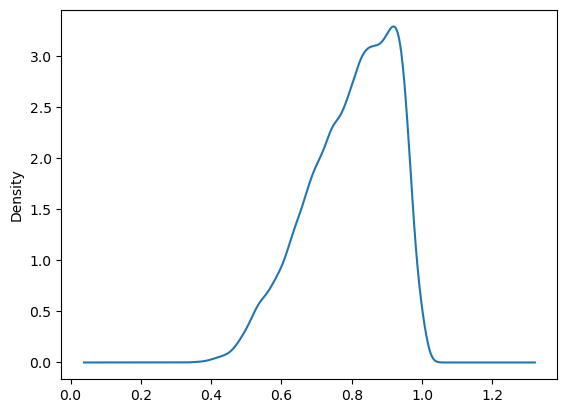

In [40]:
all_sims_image_D1 = get_similarity_distribution(D1_standard_image_vectors)
pd.Series(all_sims_image_D1).plot(kind='kde')
plt.show()